In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/BTP/dataset_r_kaggle.zip' -d '/content'

In [ ]:
!pip install path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import path
import os
%matplotlib inline
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from pathlib import Path

import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
import numpy as np
import os, shutil
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
data_path = '/content/dataset_r_kaggle/'

In [ ]:
my_images = os.listdir(data_path + 'test')

classes = ['10', '100', '20', '200', '2000', '50', '500', 'Background']

for cls in classes:
    cls_dir = data_path + 'test/' + cls
    if not os.path.exists(cls_dir):
      os.mkdir(cls_dir)


In [ ]:
print(my_images[0].split('.'))

['200', '__402', 'jpg']


In [ ]:
import shutil

for image in my_images:
  splitting = image.split('_')
  if splitting[0][-1]=='.':
    splitting[0] = splitting[0][:-1]
  shutil.copyfile(data_path+'test/'+image,data_path+'test/'+splitting[0]+'/'+image)

In [ ]:
!rm /content/dataset_r_kaggle/test/*.jpg

In [ ]:
data_agumentation=ImageDataGenerator(rescale=0./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True

)

# load training data
train_data=data_agumentation.flow_from_directory(directory=data_path + 'training',
                                                 target_size=(256,256),
                                                 class_mode='categorical',
                                                batch_size=32 
                                               )

#load validation data
val_data=ImageDataGenerator().flow_from_directory(directory=data_path + 'validation',
                                                      target_size=(256,256),
                                                       class_mode='categorical',
                                                       batch_size=32
                                                      )

#load test data
test_data=ImageDataGenerator().flow_from_directory(directory=data_path + 'test',
                                                      target_size=(256,256),
                                                       class_mode='categorical',
                                                       batch_size=32
                                                      )

Found 3566 images belonging to 8 classes.
Found 345 images belonging to 8 classes.
Found 91 images belonging to 8 classes.


EfficientNetV2S

In [ ]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=8)

82436096/82420632 [==============================] - 0s 0us/step


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(base_model_tf, to_file='enet_recog.png')

In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(8,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train_data,validation_data=val_data,epochs=50, steps_per_epoch=50,verbose=1,callbacks=[es, lr, mc])

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.5253 - accuracy: 0.4663

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 1: val_accuracy improved from -inf to 0.64638, saving model to /content
50/50 [==============================] - 248s 5s/step - loss: 1.5253 - accuracy: 0.4663 - val_loss: 1.1168 - val_accuracy: 0.6464 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.7269

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 2: val_accuracy improved from 0.64638 to 0.77681, saving model to /content
50/50 [==============================] - 221s 4s/step - loss: 0.8357 - accuracy: 0.7269 - val_loss: 0.7097 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.8106

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 3: val_accuracy improved from 0.77681 to 0.80870, saving model to /content
50/50 [==============================] - 234s 5s/step - loss: 0.5961 - accuracy: 0.8106 - val_loss: 0.5750 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8462

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 4: val_accuracy improved from 0.80870 to 0.87536, saving model to /content
50/50 [==============================] - 217s 4s/step - loss: 0.4836 - accuracy: 0.8462 - val_loss: 0.4552 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8781

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 5: val_accuracy did not improve from 0.87536
50/50 [==============================] - 135s 3s/step - loss: 0.3957 - accuracy: 0.8781 - val_loss: 0.4264 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8831
Epoch 6: val_accuracy improved from 0.87536 to 0.89275, saving model to /content
50/50 [==============================] - 217s 4s/step - loss: 0.3537 - accuracy: 0.8831 - val_loss: 0.3857 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.9056

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 7: val_accuracy improved from 0.89275 to 0.90435, saving model to /content
50/50 [==============================] - 218s 4s/step - loss: 0.3087 - accuracy: 0.9056 - val_loss: 0.3590 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9125

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 8: val_accuracy improved from 0.90435 to 0.92464, saving model to /content
50/50 [==============================] - 219s 4s/step - loss: 0.2628 - accuracy: 0.9125 - val_loss: 0.3167 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9140

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 9: val_accuracy did not improve from 0.92464
50/50 [==============================] - 130s 3s/step - loss: 0.2724 - accuracy: 0.9140 - val_loss: 0.4173 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9181
Epoch 10: val_accuracy did not improve from 0.92464
50/50 [==============================] - 136s 3s/step - loss: 0.2515 - accuracy: 0.9181 - val_loss: 0.3314 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9106
Epoch 11: val_accuracy did not improve from 0.92464
50/50 [==============================] - 132s 3s/step - loss: 0.2769 - accuracy: 0.9106 - val_loss: 0.2863 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9399
Epoch 12: val_accuracy did not improve from 0.92464
50/50 [==============================] - 131s 3s/step - loss: 0.1934 - accurac

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 15: val_accuracy improved from 0.92754 to 0.94203, saving model to /content
50/50 [==============================] - 215s 4s/step - loss: 0.1667 - accuracy: 0.9532 - val_loss: 0.2393 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9425

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 16: val_accuracy did not improve from 0.94203
50/50 [==============================] - 132s 3s/step - loss: 0.1580 - accuracy: 0.9425 - val_loss: 0.3129 - val_accuracy: 0.9101 - lr: 0.0010
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9413
Epoch 17: val_accuracy did not improve from 0.94203
50/50 [==============================] - 133s 3s/step - loss: 0.1645 - accuracy: 0.9413 - val_loss: 0.2283 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9481
Epoch 18: val_accuracy did not improve from 0.94203
50/50 [==============================] - 132s 3s/step - loss: 0.1616 - accuracy: 0.9481 - val_loss: 0.2432 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9538
Epoch 19: val_accuracy did not improve from 0.94203
50/50 [==============================] - 134s 3s/step - loss: 0.1428 - accura

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Denomination_Recognition-Models/EfficientNetV2S.h5")

Text(0.5, 1.0, 'model loss')

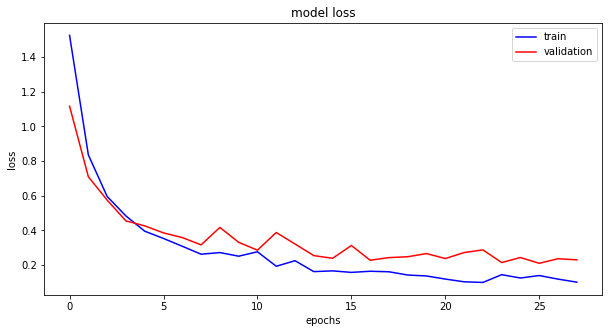

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

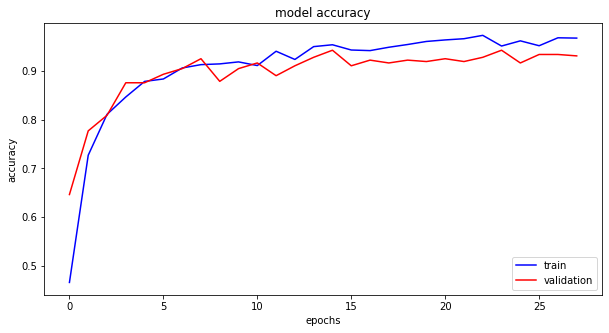

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
#EfficientNet
loss, accuracy = model_main.evaluate(train_data, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

112/112 [==============================] - 250s 2s/step - loss: 0.0844 - accuracy: 0.9722
Trainmodel_main: accuracy = 0.972238  ;  loss = 0.084389
 7/11 [==================>...........] - ETA: 7s - loss: 0.2171 - accuracy: 0.9375

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 21s 2s/step - loss: 0.2305 - accuracy: 0.9304
Validation: accuracy = 0.930435  ;  loss = 0.230536
3/3 [==============================] - 7s 2s/step - loss: 0.0482 - accuracy: 0.9890
Test: accuracy = 0.989011  ;  loss = 0.048200


2. VGG-16

In [ ]:
base_model_tf=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=8)

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func)
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(8,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                           

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train_data,validation_data=val_data,epochs=50, steps_per_epoch=50,verbose=1,callbacks=[es, lr, mc])

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 2.4186 - accuracy: 0.2541

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 1: val_accuracy improved from -inf to 0.41159, saving model to /content
50/50 [==============================] - 140s 3s/step - loss: 2.4186 - accuracy: 0.2541 - val_loss: 1.6193 - val_accuracy: 0.4116 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.4431 - accuracy: 0.4861

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 2: val_accuracy improved from 0.41159 to 0.54493, saving model to /content
50/50 [==============================] - 135s 3s/step - loss: 1.4431 - accuracy: 0.4861 - val_loss: 1.2752 - val_accuracy: 0.5449 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 1.1207 - accuracy: 0.5919

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 3: val_accuracy improved from 0.54493 to 0.63478, saving model to /content
50/50 [==============================] - 137s 3s/step - loss: 1.1207 - accuracy: 0.5919 - val_loss: 1.1075 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.6250

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 4: val_accuracy improved from 0.63478 to 0.66667, saving model to /content
50/50 [==============================] - 138s 3s/step - loss: 1.0391 - accuracy: 0.6250 - val_loss: 0.9264 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.7212

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 5: val_accuracy improved from 0.66667 to 0.71594, saving model to /content
50/50 [==============================] - 135s 3s/step - loss: 0.8192 - accuracy: 0.7212 - val_loss: 0.8367 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.7344

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 6: val_accuracy improved from 0.71594 to 0.72754, saving model to /content
50/50 [==============================] - 135s 3s/step - loss: 0.7878 - accuracy: 0.7344 - val_loss: 0.8261 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7350

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 7: val_accuracy improved from 0.72754 to 0.74203, saving model to /content
50/50 [==============================] - 135s 3s/step - loss: 0.7454 - accuracy: 0.7350 - val_loss: 0.7912 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7613

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 8: val_accuracy improved from 0.74203 to 0.74783, saving model to /content
50/50 [==============================] - 138s 3s/step - loss: 0.6807 - accuracy: 0.7613 - val_loss: 0.7432 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7813

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 9: val_accuracy improved from 0.74783 to 0.77971, saving model to /content
50/50 [==============================] - 133s 3s/step - loss: 0.6411 - accuracy: 0.7813 - val_loss: 0.6911 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.8094

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 10: val_accuracy did not improve from 0.77971
50/50 [==============================] - 134s 3s/step - loss: 0.5659 - accuracy: 0.8094 - val_loss: 0.8238 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.8112
Epoch 11: val_accuracy improved from 0.77971 to 0.80000, saving model to /content
50/50 [==============================] - 135s 3s/step - loss: 0.5328 - accuracy: 0.8112 - val_loss: 0.6316 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.8188

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 12: val_accuracy did not improve from 0.80000
50/50 [==============================] - 132s 3s/step - loss: 0.5326 - accuracy: 0.8188 - val_loss: 0.6675 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8425
Epoch 13: val_accuracy improved from 0.80000 to 0.83478, saving model to /content
50/50 [==============================] - 141s 3s/step - loss: 0.4894 - accuracy: 0.8425 - val_loss: 0.5932 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8456

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 14: val_accuracy did not improve from 0.83478
50/50 [==============================] - 133s 3s/step - loss: 0.4724 - accuracy: 0.8456 - val_loss: 0.6636 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.8506
Epoch 15: val_accuracy did not improve from 0.83478
50/50 [==============================] - 136s 3s/step - loss: 0.4646 - accuracy: 0.8506 - val_loss: 0.6100 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8565
Epoch 16: val_accuracy did not improve from 0.83478
50/50 [==============================] - 133s 3s/step - loss: 0.4445 - accuracy: 0.8565 - val_loss: 0.6081 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8650
Epoch 17: val_accuracy did not improve from 0.83478
50/50 [==============================] - 135s 3s/step - loss: 0.4082 - accura

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 22: val_accuracy did not improve from 0.83768
50/50 [==============================] - 131s 3s/step - loss: 0.3412 - accuracy: 0.8856 - val_loss: 0.5976 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8813
Epoch 23: val_accuracy improved from 0.83768 to 0.84058, saving model to /content
50/50 [==============================] - 141s 3s/step - loss: 0.3523 - accuracy: 0.8813 - val_loss: 0.5440 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.9056

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 24: val_accuracy improved from 0.84058 to 0.86087, saving model to /content
50/50 [==============================] - 149s 3s/step - loss: 0.3150 - accuracy: 0.9056 - val_loss: 0.5107 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 25/50
50/50 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.9050

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 25: val_accuracy did not improve from 0.86087
50/50 [==============================] - 141s 3s/step - loss: 0.2838 - accuracy: 0.9050 - val_loss: 0.6122 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8805
Epoch 26: val_accuracy improved from 0.86087 to 0.87536, saving model to /content
50/50 [==============================] - 139s 3s/step - loss: 0.3349 - accuracy: 0.8805 - val_loss: 0.4898 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 27/50
50/50 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.9020

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 27: val_accuracy did not improve from 0.87536
50/50 [==============================] - 134s 3s/step - loss: 0.2939 - accuracy: 0.9020 - val_loss: 0.5880 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9197
Epoch 28: val_accuracy did not improve from 0.87536
50/50 [==============================] - 143s 3s/step - loss: 0.2503 - accuracy: 0.9197 - val_loss: 0.5854 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8862
Epoch 29: val_accuracy improved from 0.87536 to 0.87826, saving model to /content
50/50 [==============================] - 133s 3s/step - loss: 0.3207 - accuracy: 0.8862 - val_loss: 0.4773 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8994

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch 30: val_accuracy did not improve from 0.87826
50/50 [==============================] - 133s 3s/step - loss: 0.2831 - accuracy: 0.8994 - val_loss: 0.5485 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 31/50
50/50 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9062
Epoch 31: val_accuracy did not improve from 0.87826
50/50 [==============================] - 129s 3s/step - loss: 0.2722 - accuracy: 0.9062 - val_loss: 0.5649 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8970
Epoch 32: val_accuracy did not improve from 0.87826
50/50 [==============================] - 132s 3s/step - loss: 0.2966 - accuracy: 0.8970 - val_loss: 0.4978 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 33/50
50/50 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9077
Epoch 33: val_accuracy did not improve from 0.87826
50/50 [==============================] - 130s 3s/step - loss: 0.2686 - accura

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Denomination_Recognition-Models/VGG-16.h5")

Text(0.5, 1.0, 'model loss')

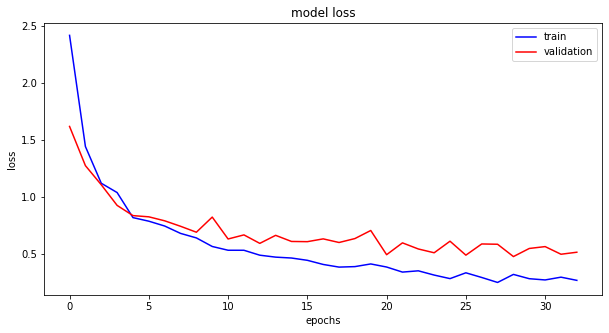

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

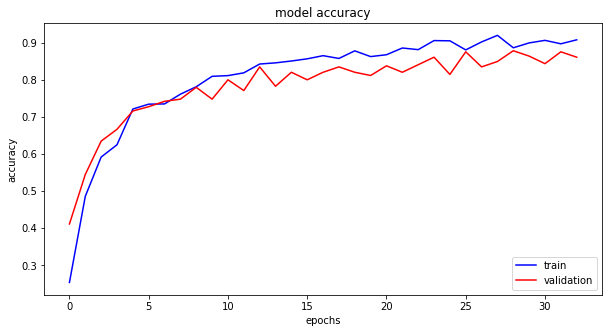

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
#VGG16
loss, accuracy = model_main.evaluate(train_data, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

112/112 [==============================] - 251s 2s/step - loss: 0.2291 - accuracy: 0.9206
Trainmodel_main: accuracy = 0.920639  ;  loss = 0.229137
 5/11 [============>.................] - ETA: 10s - loss: 0.5713 - accuracy: 0.8875

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 20s 2s/step - loss: 0.5154 - accuracy: 0.8609
Validation: accuracy = 0.860870  ;  loss = 0.515408
3/3 [==============================] - 9s 3s/step - loss: 0.1689 - accuracy: 0.9560
Test: accuracy = 0.956044  ;  loss = 0.168935


ResNet50

In [ ]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=8)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func)
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(8,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train_data,validation_data=val_data,epochs=50, steps_per_epoch=50,verbose=1,callbacks=[es, lr, mc])

Epoch 1/50
16/50 [========>.....................] - ETA: 4:55 - loss: 1.9533 - accuracy: 0.2754

KeyboardInterrupt: ignored

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Denomination_Recognition-Models/ResNet50.h5")

NameError: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

NameError: ignored

Text(0.5, 1.0, 'model accuracy')

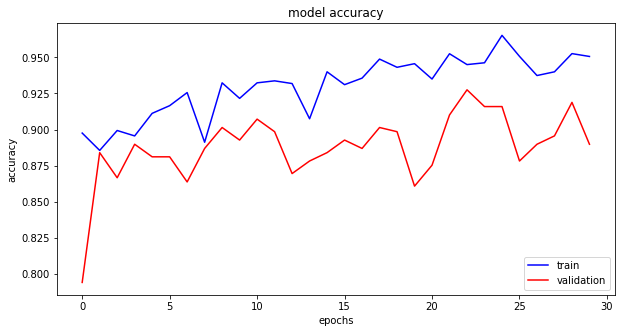

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
#ResNet50
loss, accuracy = model_main.evaluate(train_data, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

112/112 [==============================] - 250s 2s/step - loss: 0.1233 - accuracy: 0.9588
Trainmodel_main: accuracy = 0.958777  ;  loss = 0.123291
11/11 [==============================] - 20s 2s/step - loss: 0.3228 - accuracy: 0.8899
Validation: accuracy = 0.889855  ;  loss = 0.322841
3/3 [==============================] - 7s 2s/step - loss: 0.1304 - accuracy: 0.9560
Test: accuracy = 0.956044  ;  loss = 0.130400


In [ ]:
#evaluated again on efficientnetv2s
loss, accuracy = model.evaluate(train_data, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model.evaluate(val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model.evaluate(test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

112/112 [==============================] - 929s 8s/step - loss: 0.0948 - accuracy: 0.9706
Trainmodel_main: accuracy = 0.970555  ;  loss = 0.094801
 9/11 [=======================>......] - ETA: 16s - loss: 0.2650 - accuracy: 0.9201

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 87s 8s/step - loss: 0.2305 - accuracy: 0.9304
Validation: accuracy = 0.930435  ;  loss = 0.230535
3/3 [==============================] - 24s 7s/step - loss: 0.0482 - accuracy: 0.9890
Test: accuracy = 0.989011  ;  loss = 0.048201


Evaluate

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/BTP/Denomination_Recognition-Models/EfficientNetV2S.h5")

In [ ]:
from tensorflow.keras.preprocessing import image

def prediction(file_name):
    img = image.load_img(file_name, target_size=(224,224))

    image_to_test = image.img_to_array(img)

    list_of_images = np.expand_dims(image_to_test, axis=0)

    results = model.predict(list_of_images)

    single_result = results[0]

    most_likely_class_index = int(np.argmax(single_result))

    class_likelihood = single_result[most_likely_class_index]

    class_label = classes[most_likely_class_index]

    print(file_name)
    plt.imshow(img)
    
    print("This image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))

/content/dataset_r_kaggle/test/200/200.__1.jpg
This image is a 200 - Likelihood: 0.999046


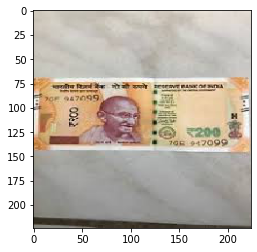

In [ ]:
prediction('/content/dataset_r_kaggle/test/200/200.__1.jpg')